In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary

In [ ]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])
    
    
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz ,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader



In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, test_loader=mnist(batch_sz) 

torch.Size([64, 1, 28, 28])


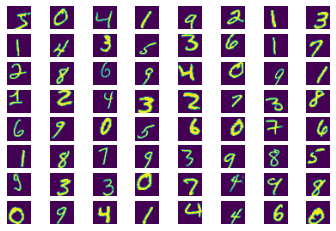

In [60]:
#Q1: Plot all the images of a training batch in a grid and verfiy that they are transformed.
tl = iter(train_loader)
batch = next(tl)

print(batch[0].shape)

for i in range(batch_sz):
  plt.subplot(8,8, i+1)
  plt.imshow(batch[0][i,:,:,:].squeeze())
  plt.axis("off")



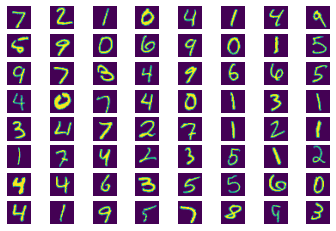

In [45]:
# Q2: Plot all the images of a test batch in a grid and verfiy that they are NOT tranformed.

tl = iter(test_loader)
batch = next(tl)

for i in range(batch_sz):
  plt.subplot(8,8, i+1)
  plt.imshow(batch[0][i,:,:,:].squeeze())
  plt.axis("off")

  


In [ ]:
# Q3 NN: define a 2 layer simple NN for mnist digit classificaiton

class NN(nn.Module):
    def __init__(self, input_size=784, output_classes=10) -> None:
        super(NN, self).__init__()
        self._layer_in = nn.Linear(input_size, 1024)
        self._layer_hidden = nn.Linear(1024, 1024)
        self._layer_out = nn.Linear(1024, output_classes)

    def forward(self, x):
        x = F.sigmoid(self._layer_in(x))
        x = F.sigmoid(self._layer_hidden(x))
        x = self._layer_out(x)

        return x


In [39]:
# Device

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# Hyperparameter

input_size = 784
output_classes = 10
lr = 0.1
epoch = 10
momentum = 0.5

# Initialize

model = NN(input_size=input_size, output_classes=output_classes).to(device)


# Loss and Optimization

loss_function = nn.CrossEntropyLoss()
opti = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


In [41]:
# Train the model

data, targets = batch

loss_l = []

acc = [] 

for i in range(epoch):
    for batch in train_loader:
        X = batch[0]
        Y = batch[1]

        X = X.reshape(X.shape[0], -1)

        X.to(device=device)
        Y.to(device=device)

        logits = model(X)

   
        loss = loss_function(logits, Y)

        loss_l.append(loss.detach().numpy())

        opti.zero_grad()
        loss.backward()

        opti.step()


/Users/luca/.pyenv/versions/Summer_School/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


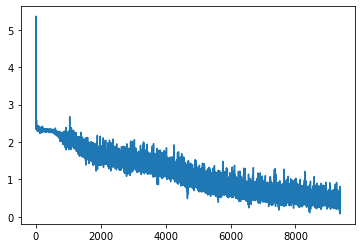

In [42]:
#Q4: Train the NN for 10 epochs and plot the loss and accuracy 

plt.figure()
plt.plot(loss_l)

In [38]:
#Q5: Save the NN and load it with a new name verify that the 
#correct weights are loaded by comparing the bias terms of the last layer

model_state = model.state_dict()

torch.save(model_state, "My Model")

loaded_model = NN(784,10)
loaded_model.load_state_dict(torch.load("My Model"))

print(model._layer_out.state_dict()['bias'])
print(loaded_model._layer_out.state_dict()['bias'])

tensor([ 0.0051, -0.0184, -0.0047,  0.0144, -0.0060,  0.0256,  0.0166,  0.0153,
         0.0278, -0.0097])
tensor([ 0.0051, -0.0184, -0.0047,  0.0144, -0.0060,  0.0256,  0.0166,  0.0153,
         0.0278, -0.0097])


In [48]:
batch.shape

AttributeError: 'list' object has no attribute 'shape'

In [58]:
#Q6: For the incorrectly labelled images collect all the images, 
#true label and predicted label in three lists. 

device = torch.device('cpu')

image = []
true_label = []
wrong_label = []
for batch in test_loader:
    X = batch[0].to(device)
    Y = batch[1].to(device)

    X = X.reshape(X.shape[0], -1)

    logits = model(X)

    label = torch.argmax(logits, axis=1)
    for i in range(X.shape[0]):
        if label[i] != Y[i]:
            image.append(X[i,-1])
            true_label.append(Y[i])
            wrong_label.append(label[i])






In [65]:
#Q7: Plot the first 10 incorrectly labeled images, 
#their true and predicted label should be in title of the plot.


for l in range(10):
    im = image[l].detach().numpy()

    im = im.reshape(im, (-1,28,28))
    plt.imshow(image[l])
    plt.show()
    # print("Ture Label = ",true_label[l].item())
    # print("Ture Label = ",true_label[l].item())




TypeError: only integer scalar arrays can be converted to a scalar index